In [1]:
import math, random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

USE_CUDA = torch.cuda.is_available()

In [2]:
def onehot_batch(indecies, n_discrete):
    _mat = np.eye(n_discrete)
    output = []
    for _index in indecies:
        _vec = _mat[_index].reshape(1, -1)
        output.append(_vec)
    output = np.concatenate(output, axis=0)
    output = torch.FloatTensor(output)
    return output

In [3]:
from collections import deque

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
            
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        return len(self.buffer)

In [4]:
# env_id = "CartPole-v0"
env_id = "Acrobot-v1"
env = gym.make(env_id)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [5]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 5000

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

In [6]:
class SFDQN(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(SFDQN, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(env.observation_space.shape[0] + env.action_space.n, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, env.observation_space.shape[0] + env.action_space.n)
        )
        self.w = np.random.randn(env.observation_space.shape[0] + env.action_space.n)
        
    def forward(self, x, a):
        x = torch.cat([x, a], dim=-1)
        psi = self.layers(x)
        return psi
    
    def act(self, state, w, epsilon):
        if random.random() > epsilon:
            state = torch.FloatTensor(state).unsqueeze(0)
            w = torch.FloatTensor(w)
            q_values = []
            for i in range(env.action_space.n):
                action = torch.zeros(1, env.action_space.n).float()
                action[0, i] = 1.
                x = torch.cat([state, action], dim=-1)
                psi = self.layers(x).view(-1)
                q = torch.sum(psi*w).item()
                q_values.append(q)
            action  = np.argmax(q_values)
        else:
            action = random.randrange(env.action_space.n)
        return action

In [7]:
model = SFDQN(env.observation_space.shape[0], env.action_space.n)
w_vec = np.random.randn(env.observation_space.shape[0] + env.action_space.n)

if USE_CUDA:
    model = model.cuda()
    
optimizer = optim.Adam(model.parameters())

replay_buffer = ReplayBuffer(10000)

In [8]:
def compute_sf_td_loss(batch_size, w_vec):
    model.train()
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)
    
    next_action = []
    for i in range(batch_size):
        _action = model.act(next_state[i], torch.tensor(w_vec).float(), epsilon=0.0)
        next_action.append(_action)
    
    state = torch.FloatTensor(np.float32(state)).requires_grad_()
    next_state = torch.FloatTensor(np.float32(next_state)).requires_grad_()
    action = onehot_batch(action, env.action_space.n).requires_grad_()
    next_action = onehot_batch(next_action, env.action_space.n).requires_grad_()
    reward = torch.FloatTensor(reward).requires_grad_()
    done = torch.FloatTensor(done).requires_grad_()
    
    phis = torch.cat([state, action], dim=-1)
    
    psis = model(state, action)
    next_psis = model(next_state, next_action)
#     q_values = torch.mm(psis, ws).view(-1)

    next_psis = next_psis * (1 - done).view(-1, 1)
    expected_psis = phis + gamma * next_psis
    expected_psis = expected_psis.requires_grad_()
    
    loss = (psis - expected_psis).pow(2).mean()
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss

In [9]:
def train_w(w_vec, batch_size, alpha=0.001, iter_size=1000):
    for i in range(iter_size):
        state, action, reward, next_state, done = replay_buffer.sample(batch_size)
        action = onehot_batch(action, env.action_space.n).numpy()
        phis = np.concatenate([state, action], axis=-1)
        r_loss = reward - np.matmul(phis, w_vec)
        w_losses = np.multiply(r_loss.reshape(-1, 1), phis)
        w_loss = np.mean(w_losses, axis=0)
        w_vec = w_vec + alpha*w_loss
    return w_vec, np.mean(np.abs(r_loss))

In [10]:
def plot(frame_idx, rewards, losses, r_losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('sf td loss')
    plt.plot(losses)
    plt.subplot(133)
    plt.title('reward regression loss')
    plt.plot(r_losses)
    plt.show()

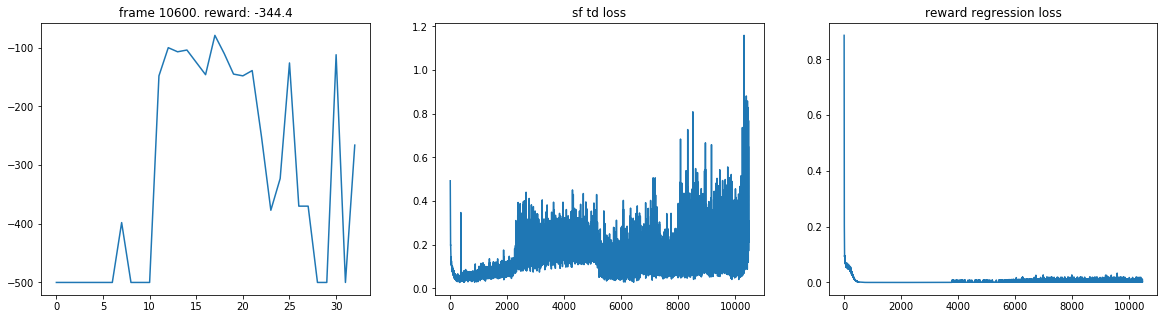

KeyboardInterrupt: 

In [11]:
num_frames = 200000
batch_size = 128
gamma      = 0.99

losses = []
r_losses = []
all_rewards = []
episode_reward = 0

state = env.reset()
for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx)
    action = model.act(state, w_vec, epsilon)
    if type(action) == torch.Tensor:
        action = action.item()
    next_state, reward, done, _ = env.step(action)
    replay_buffer.push(state, action, reward, next_state, done)
    
    state = next_state
    episode_reward += reward
    
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if len(replay_buffer) > batch_size:
        w_vec, r_loss = train_w(w_vec, batch_size)
        loss = compute_sf_td_loss(batch_size, w_vec)
        losses.append(loss.data.item())
        r_losses.append(r_loss)
        
    if frame_idx % 200 == 0:
        plot(frame_idx, all_rewards, losses, r_losses)

In [92]:
torch.save(model.state_dict(), "./data/sfdqn_policy.pth")

array([ 0.05359773, -0.04824943,  0.14589544, -0.03921225,  0.99896188,
        0.996596  ])